## Importing Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras

2022-12-09 07:34:38.505605: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
df = pd.read_csv("/kaggle/input/gtzan-dataset-music-genre-classification/Data/features_3_sec.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [3]:
df.shape

(9990, 60)

In [4]:
df.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [5]:
df=df.drop(labels="filename",axis=1)

## Understanding the audio files

In [6]:
audio_recording="/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/country/country.00050.wav"
data,sr=librosa.load(audio_recording)
print(type(data),type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [7]:
librosa.load(audio_recording,sr=45600)

(array([ 0.04582627,  0.06254332,  0.0583379 , ..., -0.13857861,
        -0.11823352, -0.05911855], dtype=float32),
 45600)

In [8]:
import IPython
IPython.display.Audio(data,rate=sr)

## Visualising audio files

### Plotting Raw wave files

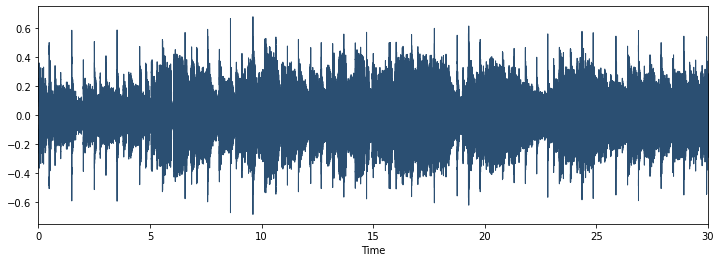

In [9]:
plt.figure(figsize=(12,4))
librosa.display.waveplot(data,color="#2B4F72")
plt.show()

**Spectrogram**

/opt/conda/lib/python3.7/site-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


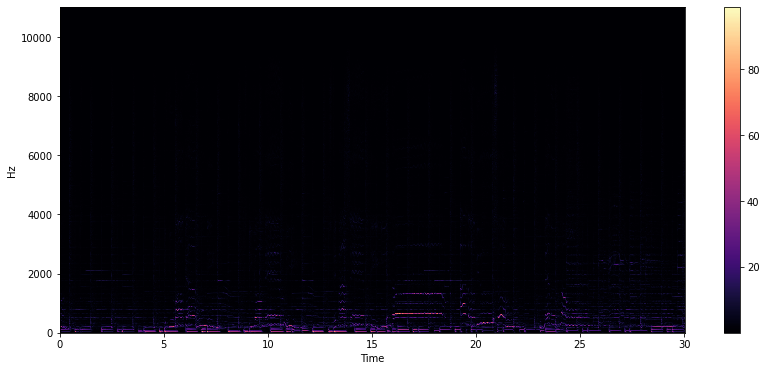

In [10]:
stft=librosa.stft(data)
stft_db=librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft,sr=sr,x_axis='time',y_axis='hz')
plt.colorbar()

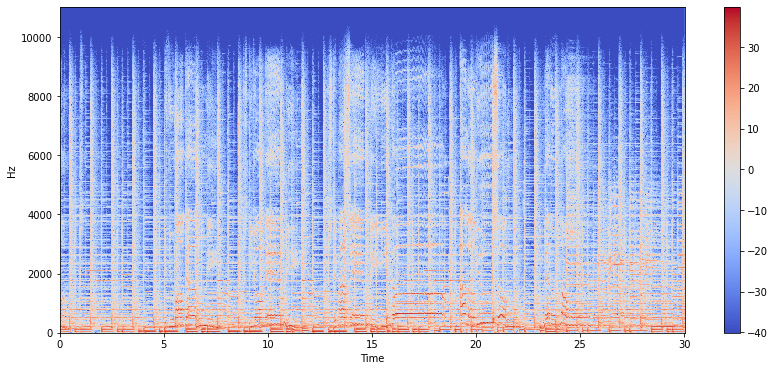

In [11]:
stft=librosa.stft(data)
stft_db=librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14,6))
librosa.display.specshow(stft_db,sr=sr,x_axis='time',y_axis='hz')
plt.colorbar()

**Spectral Roll-Off**

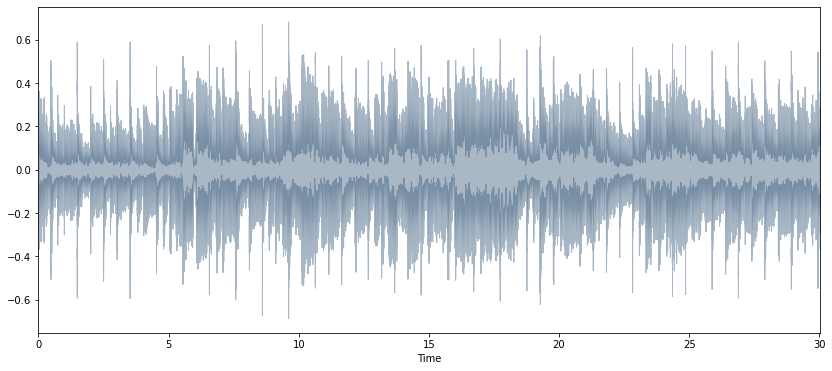

In [12]:
spectral_rolloff=librosa.feature.spectral_rolloff(data+0.01,sr=sr)[0]
plt.figure(figsize=(14,6))
librosa.display.waveplot(data,sr=sr,alpha=0.4,color="#2B4F72")

**Chroma Feature**

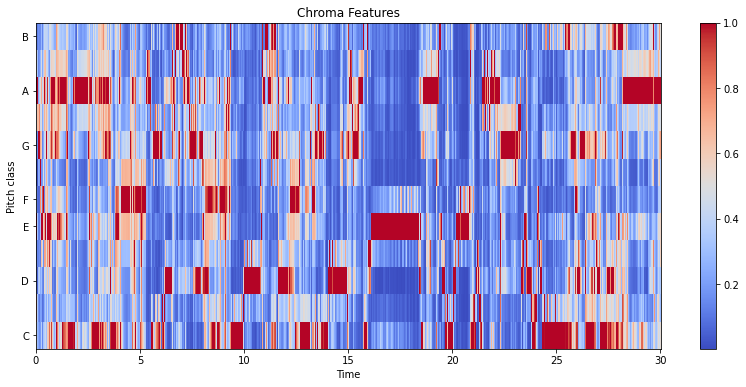

In [13]:
import librosa.display as lplt
chroma = librosa.feature.chroma_stft(data,sr=sr)
plt.figure(figsize=(14,6))
lplt.specshow(chroma,sr=sr,x_axis="time",y_axis="chroma",cmap="coolwarm")
plt.colorbar()
plt.title("Chroma Features")
plt.show()

**Zero Crossing Rate**

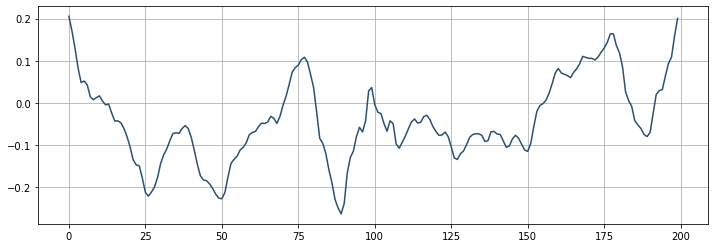

In [14]:
start=1000
end=1200
plt.figure(figsize=(12,4))
plt.plot(data[start:end],color="#2B4F72")
plt.grid()

In [15]:
zero_cross_rate=librosa.zero_crossings(data[start:end],pad=False)
print("the numbert of zero_crossings is :", sum(zero_cross_rate))

the numbert of zero_crossings is : 8


**Feature Extraction**

In [16]:
class_list=df.iloc[:,-1]
converter=LabelEncoder()

In [17]:
y=converter.fit_transform(class_list)
y

array([0, 0, 0, ..., 9, 9, 9])

In [18]:
print(df.iloc[:,:-1])

      length  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0      66149          0.335406         0.091048  0.130405  0.003521   
1      66149          0.343065         0.086147  0.112699  0.001450   
2      66149          0.346815         0.092243  0.132003  0.004620   
3      66149          0.363639         0.086856  0.132565  0.002448   
4      66149          0.335579         0.088129  0.143289  0.001701   
...      ...               ...              ...       ...       ...   
9985   66149          0.349126         0.080515  0.050019  0.000097   
9986   66149          0.372564         0.082626  0.057897  0.000088   
9987   66149          0.347481         0.089019  0.052403  0.000701   
9988   66149          0.387527         0.084815  0.066430  0.000320   
9989   66149          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              19

**Scaling the features**

In [19]:
from sklearn.preprocessing import StandardScaler
fit=StandardScaler()
X=fit.fit_transform(np.array(df.iloc[:,:-1],dtype=float))

## Dividing Training and Testing Dataset

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33)

In [21]:
len(y_test)

3297

In [22]:
len(y_train)

6693

## Building the model


In [23]:
from tensorflow.keras.models import Sequential

In [24]:
def trainModel(model,epochs,optimizer):
    batch_size=128
    model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics='accuracy')
    return model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=batch_size)

In [25]:
def plotValidate(history):
    print("Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [26]:
import tensorflow as tf

In [27]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(512,activation='relu',input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(256,activation='relu'),
    keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(10,activation='softmax'),
])

print(model.summary())
model_history=trainModel(model=model,epochs=600,optimizer='adam')

2022-12-09 07:36:46.217693: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-09 07:36:46.221434: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-09 07:36:46.277938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 07:36:46.278695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-12-09 07:36:46.278830: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-09 07:36:46.306943: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               30208     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8

2022-12-09 07:36:48.523741: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-09 07:36:48.536483: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000170000 Hz
2022-12-09 07:36:49.058450: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


52/53 [============================>.] - ETA: 0s - loss: 1.8993 - accuracy: 0.3371

2022-12-09 07:36:50.009992: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


53/53 [==============================] - 2s 14ms/step - loss: 1.8894 - accuracy: 0.3404 - val_loss: 1.1819 - val_accuracy: 0.5993
Epoch 2/600
53/53 [==============================] - 0s 4ms/step - loss: 1.1741 - accuracy: 0.5952 - val_loss: 0.9111 - val_accuracy: 0.6973
Epoch 3/600
53/53 [==============================] - 0s 4ms/step - loss: 0.9438 - accuracy: 0.6738 - val_loss: 0.7950 - val_accuracy: 0.7361
Epoch 4/600
53/53 [==============================] - 0s 4ms/step - loss: 0.7934 - accuracy: 0.7298 - val_loss: 0.7140 - val_accuracy: 0.7628
Epoch 5/600
53/53 [==============================] - 0s 4ms/step - loss: 0.6973 - accuracy: 0.7642 - val_loss: 0.6486 - val_accuracy: 0.7831
Epoch 6/600
53/53 [==============================] - 0s 4ms/step - loss: 0.6188 - accuracy: 0.7939 - val_loss: 0.5966 - val_accuracy: 0.8044
Epoch 7/600
53/53 [==============================] - 0s 4ms/step - loss: 0.5717 - accuracy: 0.8094 - val_loss: 0.5941 - val_accuracy: 0.8032
Epoch 8/600
53/53 [=====

## Model Evaluation

In [28]:
test_loss,test_acc=model.evaluate(X_test,y_test,batch_size=128)
print("The test loss is ",test_loss)
print("The best accuracy is: ",test_acc*100)

26/26 [==============================] - 0s 2ms/step - loss: 0.5996 - accuracy: 0.9196
The test loss is  0.5995964407920837
The best accuracy is:  91.96239113807678
